## Exercise set 4: the generalized random forest

In this exercise set we will be working with the [generalized random forest](https://github.com/grf-labs/grf) by Athey et al. The package is written for the R programming language, and while there is a R-to-python interface in [rpy2](https://rpy2.bitbucket.io/) it can be tricky to get working. If you run into trouble, you can consider saving your data to a csv file and work directly in [R](https://www.r-project.org/) through [Rstudio](https://rstudio.com/products/rstudio/download/). 

In [2]:
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import math
plt.style.use('ggplot')

To highlight the usefulness of GRF we will be working with synthetic data in this exercise. In particular we will synthetically add a treatment effect to a dataset in which there otherwise is none. Furthermore we will make this effect heterogeneous by adding noise, and by making it depend on a single continuous variable as well as a categorical variable. 

>**Ex. 4.1.1:** Complete the code below to simulate data according to
$$
T = U(0,1) > 0.5 \\ 
Y(T=0) = X\beta + \epsilon \\ 
\tau(X) =  \begin{cases}
        \frac{10}{1 + e^{-\gamma X_0}} + \nu & D = 0\\ 
        \nu & D = 1
        \end{cases}\\ 
Y(T=1) = Y(0) + \tau(X) \\ 
$$
where $\epsilon, \nu$ are simply noise terms distributed according to $\mathcal{N}(0,1)$ and $\beta$ is an `N_FEATURES` vector of random parameters. $\gamma$ is a scalar parameter.


In [3]:
N_SAMPLES = 10000
N_FEATURES = 5
GAMMA = 3
BETA = np.random.uniform(0,1, size = N_FEATURES)

X = np.random.normal(size = (N_SAMPLES, N_FEATURES)) # The covariates
D = np.random.choice([0,1], size = N_SAMPLES) # Random assignment of treatment effect / heterogeneity
T = np.random.uniform(0,1, size = N_SAMPLES) > 0.5 # Random assignment of treatment.

Y0 = X @ BETA + np.random.normal()
X0 = X[:,0]
Tau = (10/(1+np.exp(-GAMMA*X0)))*(1-D) + np.random.normal() # Treament effect
Y1 = Y0 + Tau
y = Y0 + T*(Y1 - Y0) # Observed outcome

**Ex. 4.1.2:** Create a two-subplot figure, and plot $Y(0)$ and $Y(1)$ in one subplot against $X_0$. Plot $\tau(x)$ against $X_0$ in the other subplot. What do you see? Why do we observe $\tau=0$ in many cases?

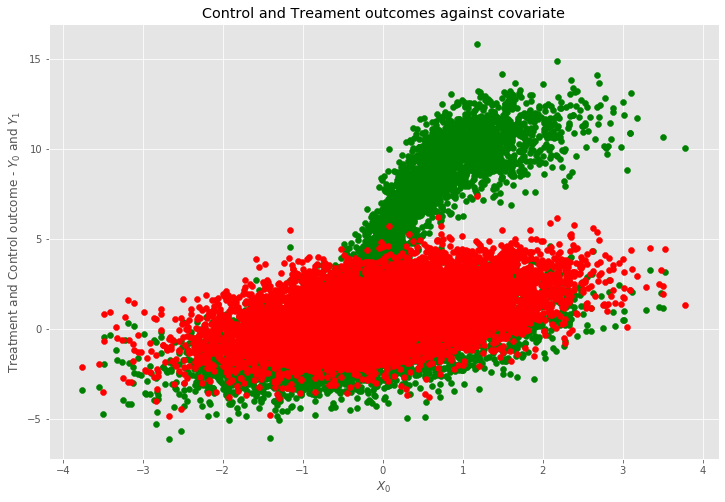

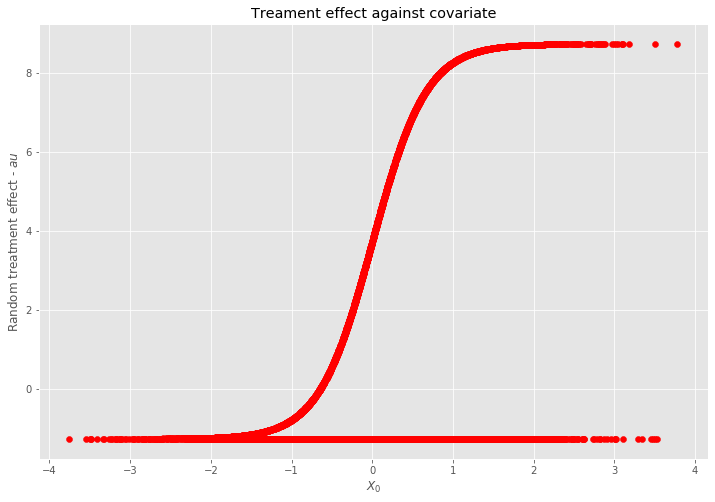

In [4]:
#fig = plt.subplots(2, figsize = (15,20))

# First plot - Y0, Y1 and X0
plt.figure(figsize=(12,8))
plt.title('Control and Treament outcomes against covariate')
plt.scatter(X0, Y1, c='g')
plt.scatter(X0, Y0, c='r')
plt.ylabel('Treatment and Control outcome - $Y_0$ and $Y_1$')
plt.xlabel('$X_0$')
plt.show()

#Second plot - Tau and X0
plt.figure(figsize=(12,8))
plt.title('Treament effect against covariate')
plt.scatter(X0, Tau, c = 'r')
plt.ylabel('Random treatment effect - $\tau$')
plt.xlabel('$X_0$')
plt.show()

Answer: We see that the treatment effect depend on $X_0$, which indicates that we have succesfully simulated heterogeneous treatment effects, as desired.

We furthermore observe $\tau=0$ since we have constructed $\tau$ in such a way, that it depends on the random assignment of D. When D=1, $\tau=v$ which is just 'noise' drawn from a standard normal distribution. Thus $\tau$ is probably not exactly 0, but almost 0. 

>**Ex 4.1.3.** Import `statsmodels` and estimate a simple linear regression
$$
y = \alpha + \delta_0 T + \sum_k \beta_k X_k + \epsilon
$$
>What is your estimate of $\hat{\delta}_0$? How does this number fit with the figures you drew in the previous exercise? Do you have any suggestions for improving the estimate of the model, comment on whether your improvements would provide unbiased estimates of $\tau$? 
>
> **Bonus:** fit your improved model, and relate the parameters you estimate to the figure you plotted in the previous question.

In [12]:
from statsmodels.formula.api import ols

#Extract relevant variables into dataframe
df = pd.concat([pd.DataFrame(X, columns=[f'X{i}' for i in range(N_FEATURES)]),
                pd.DataFrame(T, columns = ['T']),
                pd.DataFrame(y, columns = ['y'])],
               axis = 1)

#Estimate the model
model = ols('y ~ T + X0 + X1 + X2 + X3 + X4', df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     1338.
Date:                Wed, 18 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:00:08   Log-Likelihood:                -23004.
No. Observations:               10000   AIC:                         4.602e+04
Df Residuals:                    9993   BIC:                         4.607e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9249      0.034     26.899      0.000       0.858       0.992
T[T.True]      1.2838      0.048     26.574      0.000       1.189       1.379
X0             1.6082      0.024     66.801      0.000       1.561       1.655
X1             0.5018      0.024     21.012      0.000       0.455       0.549
X2             0.7664      0.024     31.551      0.000       0.719       0.814
X3             0.6960      0.024     29.002      0.000       0.649       0.743
X4             0.5812      0.024     24.162      0.000       0.534       0.628
==============================================================================
Omnibus:                     1202.576   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1690.024
Skew:                           0.945   Prob(JB):                         0.00
Kurtosis:                       3.695   Cond. No.                         2.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
T.mean()

0.5065

>**Ex. 4.1.4:** For this question we will need to move into R (or use rpy2). If you are working in python you can skip this step, otherwise do the following. 
>
> Save a dataframe, containing $X$, $y$, $T$, and $D$ as a csv file on your computer.

In [17]:
#Extract relevant variables into dataframe
df_for_r = pd.concat([pd.DataFrame(X, columns=[f'X{i}' for i in range(N_FEATURES)]),
                      pd.DataFrame(T, columns = ['T']),
                      pd.DataFrame(y, columns = ['y']),
                      pd.DataFrame(D, columns = ['D'])],
                     axis = 1)

df_for_r.to_csv('/Users/Esben/Dropbox/Sociologi/6. semester/Social Data Science/Øvelser/exercise_5_df.csv')

>**Ex. 4.1.5:** Open up R and read the data you just saved into a dataframe(or work in rpy2). Install and load the two libraries `tidyverse` and `grf`.
>
> _Hint:_ to install the required packages. run this:
> ```R
> install.packages("tidyverse")
> install.packages("grf")
> ```

In [9]:
# Your answer either here, or in R

>**Ex. 4.1.5:** Copy the following code into R to split your dataframe into two matrices, `X`, and `y`. Implement the exact same procedure to create a third matrix `W` which contains the treatment indicator (**Note** `T` is a reserved name in R, so name your third matrix `W`).
>```R
>X <- df %>%
  select(X0, X1, X2, X3, X4, D) %>% 
  as.matrix()
>
>y <- df %>%
  select(y) %>% 
  as.matrix()
>```
> Finally spend some time poking around the [GRF documentation](https://github.com/grf-labs/grf). See if you can figure out how to estimate a GRF model, once you have the three matrices you need (this is way simpler than you might expect).

In [ ]:
# Your answer either here, or in R

>**Ex.4.1.6:** Estimate a causal forest model using the GRF package, and store the result in a new variable `cf`. Then use the following line to create a dataframe of predicted treatment effects on the same data that you trained the model on. 
>```R
>cf <- # Estimate a generalized RF model aimed at treatment effects.
>tau <- predict(cf, X)
>```
> Once you have your individual treatment effects, run the following line, to save them in a csv file. 
> ```R
> write.csv(tau, "individual_treatment_effects.csv")
> ```

In [ ]:
# Your answer either here, or in R

>**Ex.4.1.6:** This concludes our venture into R. Now load the treatment effects into a pandas dataframe, and plot a scatterplot of the estimated individual treatment effects against the simulated "true" ITE's `Tau` that you produced in the beginning of this exercise set.

In [ ]:
# Your answer either here